# Retrieving Data from the JAO Auction Platform

In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import glob
import requests
from datetime import datetime, timedelta
import pytz
from jao import JaoAPIClient
from tqdm.notebook import tqdm
import yaml

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)
background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        figure_size=[7, 7/1.618],
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)


%load_ext blackcellmagic
%matplotlib inline

- The supported formats for Timestamp or Date parameters are
    - yyyy-MM-dd
    - yyyy-MM-dd-HH:mm:ss
- All Timestamp and Date parameters are stored and used in UTC (Coordinated Universal Time)
- Boolean parameters support values like 1 or 0, but also true or false
- All parameter values should be encoded in UTF-8

As precisely 31 days are returned for every request, we will run a for loop over 31 day intervals to retrieve multiple years of data. For now, we are querying from start of December 2019 until the end of January 2024.

### How does the API work?

Set the parameters for the query:

In [12]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [13]:
jao_token = config["jao"]
import_date = datetime(2019, 1, 1)
border = "DE-CH"

In [14]:
# format query date
qry_import_date = (
    import_date.astimezone(pytz.timezone("UTC"))
    .strftime("%Y-%m-%d-%H:%M:%S")
    .replace(":", "%3A")
    .replace("23%", "13%")
)

qry_import_date

'2018-12-31-13%3A00%3A00'

In [22]:
qry_api_call = "https://api.jao.eu/OWSMP/getauctions?corridor={0}&horizon=Daily&fromdate={1}".format(
    border, qry_import_date
)

sess = requests.session()
# sess.proxies = {'https' : if necessary, 'http' : if necessary}
sess.headers.update({"AUTH_API_KEY": jao_token})
qry_resp = sess.get(qry_api_call)

# As dates are UTC, convert to CH time and get the correct day by adding one day
jao_results = (
    pd.DataFrame(qry_resp.json())
    .assign(
        marketPeriodStart=lambda x: pd.to_datetime(
            x["marketPeriodStart"], utc=True
        ).dt.date
        + timedelta(days=1),
    )
    .query("not cancelled")
)

The API returns 31 days starting with the query day with 24h of auction data each. These results are contained in a column of listed dictionaries, which have to be exploded:

In [28]:
(
    pd.concat(
        [
            jao_results.explode("results")
            .filter(["marketPeriodStart"])
            .reset_index(drop=True),
            pd.json_normalize(jao_results.explode("results")["results"]).reset_index(
                drop=True
            ),
        ],
        axis=1,
    )
    .rename(
        columns={
            "corridorCode": "corridor",
            "marketPeriodStart": "date",
            "auctionPrice": "price",
            "productHour": "hour",
            "offeredCapacity": "ATC",
        }
    )
    .filter(["corridor", "date", "hour", "price", "allocatedCapacity", "ATC"])
    .reset_index(drop=True)
)

,corridor,date,hour,price,allocatedCapacity,ATC
0,DE-CH,2019-01-01,00:00-01:00,19.51,567.0,567.0
1,DE-CH,2019-01-01,01:00-02:00,21.96,567.0,567.0
2,DE-CH,2019-01-01,02:00-03:00,27.12,567.0,567.0
3,DE-CH,2019-01-01,03:00-04:00,27.62,567.0,567.0
4,DE-CH,2019-01-01,04:00-05:00,25.19,567.0,567.0
...,...,...,...,...,...,...
739,DE-CH,2019-01-08,22:00-23:00,33.58,517.0,517.0
740,DE-CH,2019-01-08,23:00-24:00,39.87,517.0,517.0
741,DE-CH,2019-01-08,10:00-11:00,27.28,517.0,517.0
742,DE-CH,2019-01-08,11:00-12:00,27.20,517.0,517.0


### Writing a reusable function for queries

In [9]:
def get_auctions(import_dates: list, jao_token: str, border: str, df_list: list):
    """
    Retrieves auction data from the JAO API for the specified import dates and border.

    Parameters:
    import_dates (list): List of import dates.
    jao_token (str): JAO API token for authentication.
    border (str): Border for which the auction data is retrieved.
    df_list (list): List to store the retrieved auction data.

    Returns:
    pandas.DataFrame: Concatenated and sorted auction data.
    """
    for idx, import_date in enumerate(tqdm(import_dates)):
        # format query date
        qry_import_date = (
            import_date.astimezone(pytz.timezone("UTC"))
            .strftime("%Y-%m-%d-%H:%M:%S")
            .replace(":", "%3A")
            .replace("23%", "13%")
        )

        qry_api_call = "https://api.jao.eu/OWSMP/getauctions?corridor={0}&horizon=Daily&fromdate={1}".format(
            border, qry_import_date
        )

        sess = requests.session()
        # sess.proxies = {'https' : if necessary, 'http' : if necessary}
        sess.headers.update({"AUTH_API_KEY": jao_token})
        qry_resp = sess.get(qry_api_call)

        # As dates are UTC, convert to CH time and get the correct day by adding one day
        jao_results = (
            pd.DataFrame(qry_resp.json())
            .assign(
                marketPeriodStart=lambda x: pd.to_datetime(
                    x["marketPeriodStart"], utc=True
                ).dt.date
                + timedelta(days=1),
            )
            .query("not cancelled")
        )

        jao_prices = (
            pd.concat(
                [
                    jao_results.explode("results")
                    .filter(["marketPeriodStart"])
                    .reset_index(drop=True),
                    pd.json_normalize(
                        jao_results.explode("results")["results"]
                    ).reset_index(drop=True),
                ],
                axis=1,
            )
            .rename(
                columns={
                    "corridorCode": "corridor",
                    "marketPeriodStart": "date",
                    "auctionPrice": "price",
                    "productHour": "hour",
                    "offeredCapacity": "ATC",
                }
            )
            .filter(["corridor", "date", "hour", "price", "allocatedCapacity", "ATC"])
            .reset_index(drop=True)
            .assign(
                delivery_begin_time_ch=lambda x: pd.to_datetime(
                    x["date"]
                ).dt.tz_localize("Europe/Berlin")
                + pd.to_timedelta(
                    x["hour"].str.split("-").str[0].str.split(":").str[0].astype(int),
                    unit="h",
                ),
            )
            .sort_values(["date", "hour"])
            .reset_index(drop=True)
        )

        df_list.append(jao_prices)

    return (
        pd.concat(df_list).sort_values("delivery_begin_time_ch").reset_index(drop=True)
    )

### DE-CH Auctions

In [10]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
jao_token = config["jao"]
import_dates = [
    datetime(2019, 1, 1) + i * timedelta(days=31)
    for i in range(
        int(np.floor((datetime.today().date() - datetime(2019, 1, 1).date()).days / 31))
    )
]
border = "DE-CH"
jao_prices_list = []

In [11]:
jao_prices = get_auctions(import_dates=import_dates, jao_token=jao_token, border=border, df_list=jao_prices_list)
jao_prices

  0%|          | 0/61 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
jao_prices.to_csv("jao_prices_DE-CH.csv", index=False)

### CH-DE Auctions

In [ ]:
jao_token = "26212512-48ba-4b5d-adf1-34c01ea64033"
import_dates = [
    datetime(2019, 1, 1) + i * timedelta(days=31)
    for i in range(
        int(np.floor((datetime.today().date() - datetime(2019, 1, 1).date()).days / 31))
    )
]
border = "CH-DE"
jao_prices_list = []

In [ ]:
jao_prices = get_auctions(import_dates=import_dates, jao_token=jao_token, border=border, df_list=jao_prices_list)
jao_prices

  0%|          | 0/60 [00:00<?, ?it/s]

,corridor,date,hour,price,allocatedCapacity,ATC,delivery_begin_time_ch
0,CH-DE,2019-01-01,00:00-01:00,0.0,4232.0,4233.0,2019-01-01 00:00:00+01:00
1,CH-DE,2019-01-01,01:00-02:00,0.0,4232.0,4233.0,2019-01-01 01:00:00+01:00
2,CH-DE,2019-01-01,02:00-03:00,0.0,4232.0,4233.0,2019-01-01 02:00:00+01:00
3,CH-DE,2019-01-01,03:00-04:00,0.0,4232.0,4233.0,2019-01-01 03:00:00+01:00
4,CH-DE,2019-01-01,04:00-05:00,0.0,4232.0,4233.0,2019-01-01 04:00:00+01:00
...,...,...,...,...,...,...,...
45283,CH-DE,2024-02-03,19:00-20:00,0.0,4349.0,4350.0,2024-02-03 19:00:00+01:00
45284,CH-DE,2024-02-03,20:00-21:00,0.0,4335.0,4350.0,2024-02-03 20:00:00+01:00
45285,CH-DE,2024-02-03,21:00-22:00,0.0,4345.0,4350.0,2024-02-03 21:00:00+01:00
45286,CH-DE,2024-02-03,22:00-23:00,0.0,4338.0,4350.0,2024-02-03 22:00:00+01:00


In [ ]:
jao_prices.to_csv("jao_prices_CH-DE.csv", index=False)

### Two different prices?

In [13]:
chde = pd.read_csv("jao_prices_CH-DE.csv", parse_dates=["delivery_begin_time_ch"])
dech = pd.read_csv("jao_prices_DE-CH.csv", parse_dates=["delivery_begin_time_ch"])

c:\Users\mathi\miniconda3\envs\statslab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
c:\Users\mathi\miniconda3\envs\statslab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
c:\Users\mathi\miniconda3\envs\statslab\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


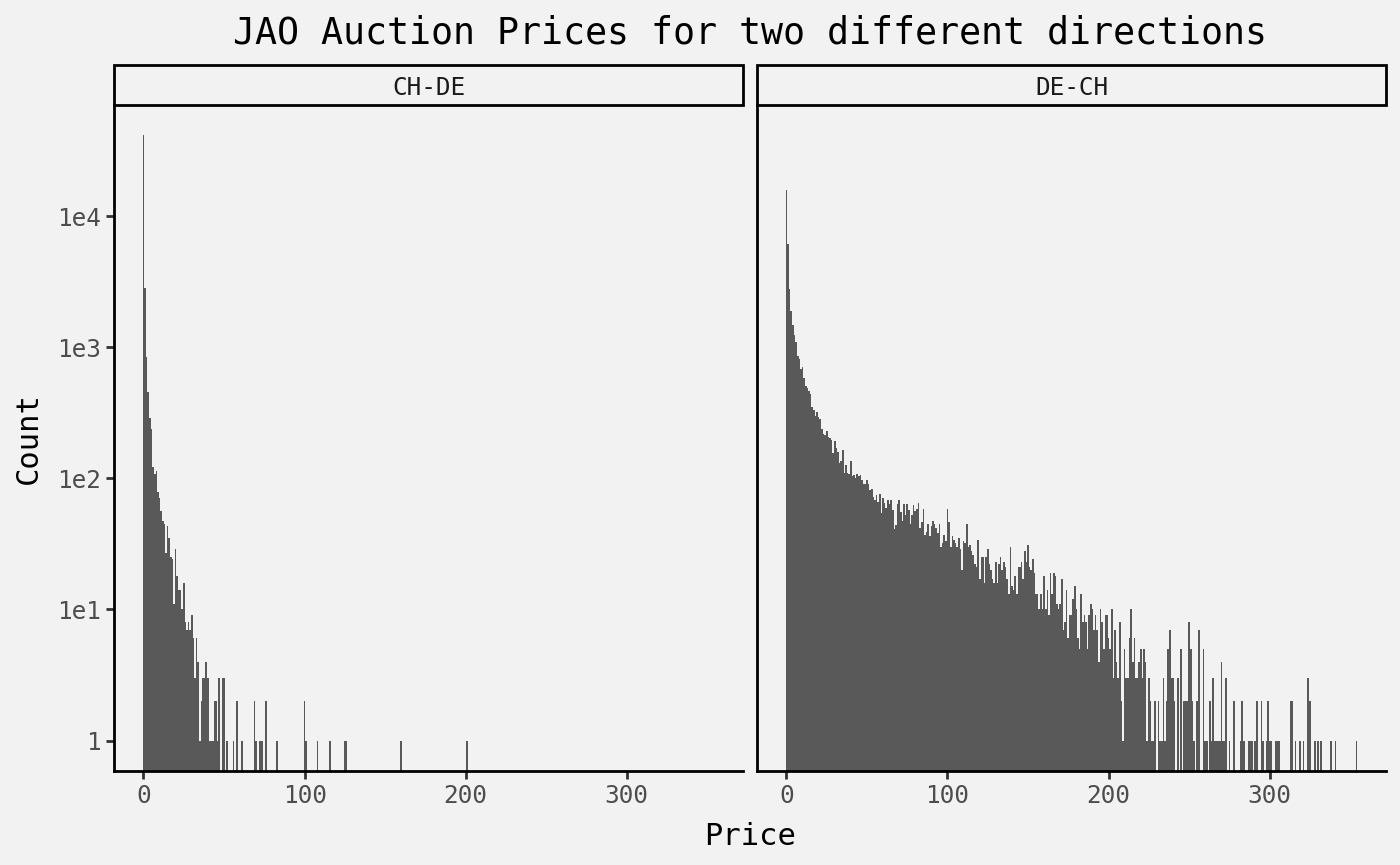

In [14]:
(
    pn.ggplot(
        data=chde.filter(["delivery_begin_time_ch", "price"])
        .rename(columns={"price": "CH-DE"})
        .merge(
            dech.filter(["delivery_begin_time_ch", "price"]).rename(
                columns={"price": "DE-CH"}
            ),
            how="left",
            on="delivery_begin_time_ch",
        )
        .melt("delivery_begin_time_ch"),
        mapping=pn.aes("value"),
    )
    + pn.geom_histogram(binwidth=1)
    + pn.facet_wrap("~ variable")
    + pn.labs(title="JAO Auction Prices for two different directions", x="Price", y="Count")
    + pn.scale_y_log10()
)

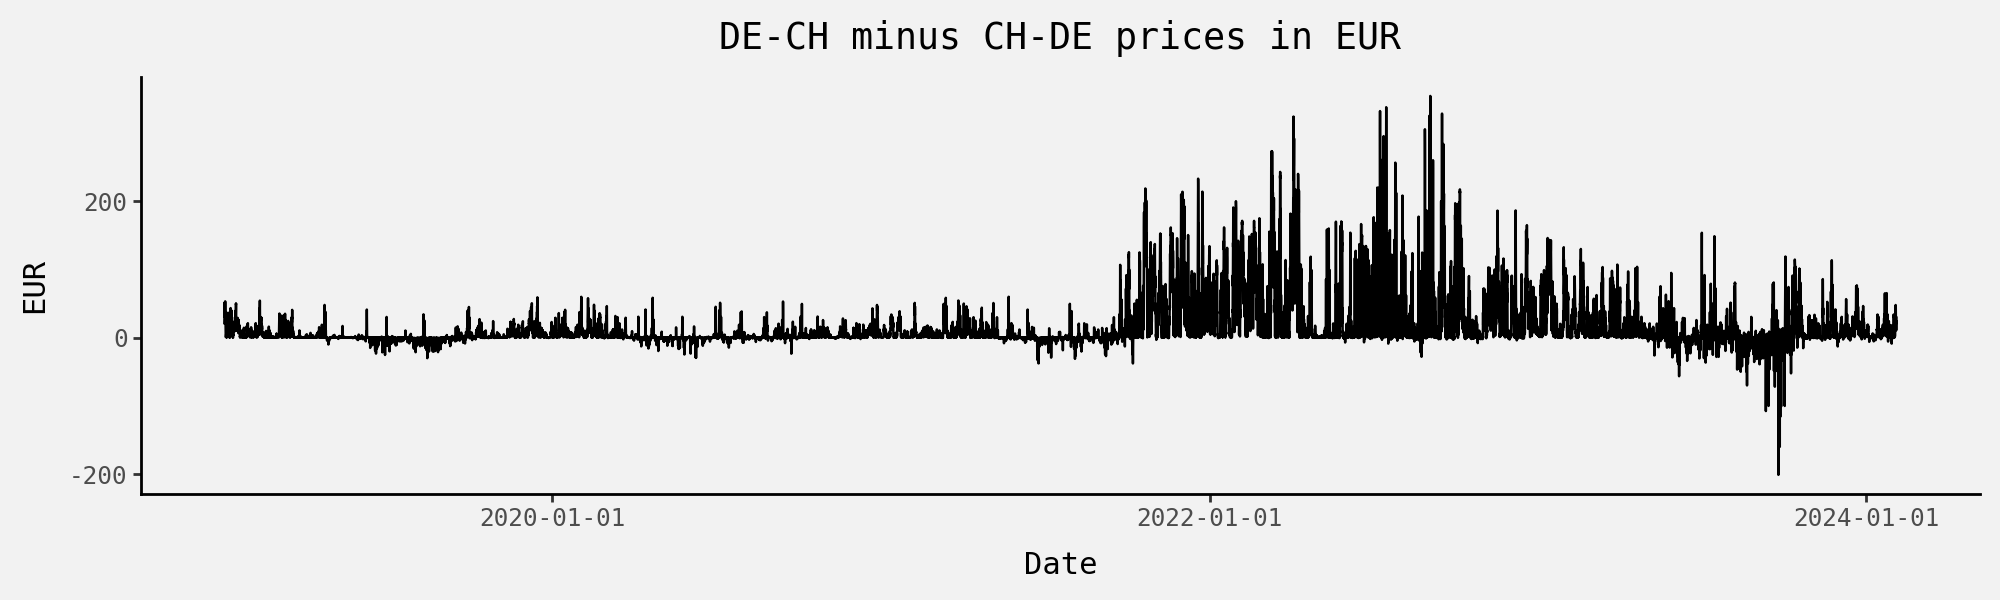

In [15]:
(
    pn.ggplot(
        data=(
            chde.filter(["delivery_begin_time_ch", "price"])
            .rename(columns={"price": "CH-DE"})
            .merge(
                dech.filter(["delivery_begin_time_ch", "price"]).rename(
                    columns={"price": "DE-CH"}
                ),
                how="left",
                on="delivery_begin_time_ch",
            )
            .assign(delta=lambda x: x["DE-CH"] - x["CH-DE"])
            .assign(
                delivery_begin_time_ch=lambda x: pd.to_datetime(
                    x["delivery_begin_time_ch"], utc=True
                )
            )
        ),
        mapping=pn.aes(x="delivery_begin_time_ch", y="delta"),
    )
    + pn.geom_line()
    + pn.labs(title="DE-CH minus CH-DE prices in EUR", y="EUR", x="Date")
    + pn.theme(figure_size=[10, 3])
)

In [16]:
spot_ch = pd.read_csv("day_ahead_prices_CH.csv")
spot_de = pd.read_csv("day_ahead_prices_DE_LU.csv")
capacity_dech = pd.read_csv("jao_prices_DE-CH.csv")

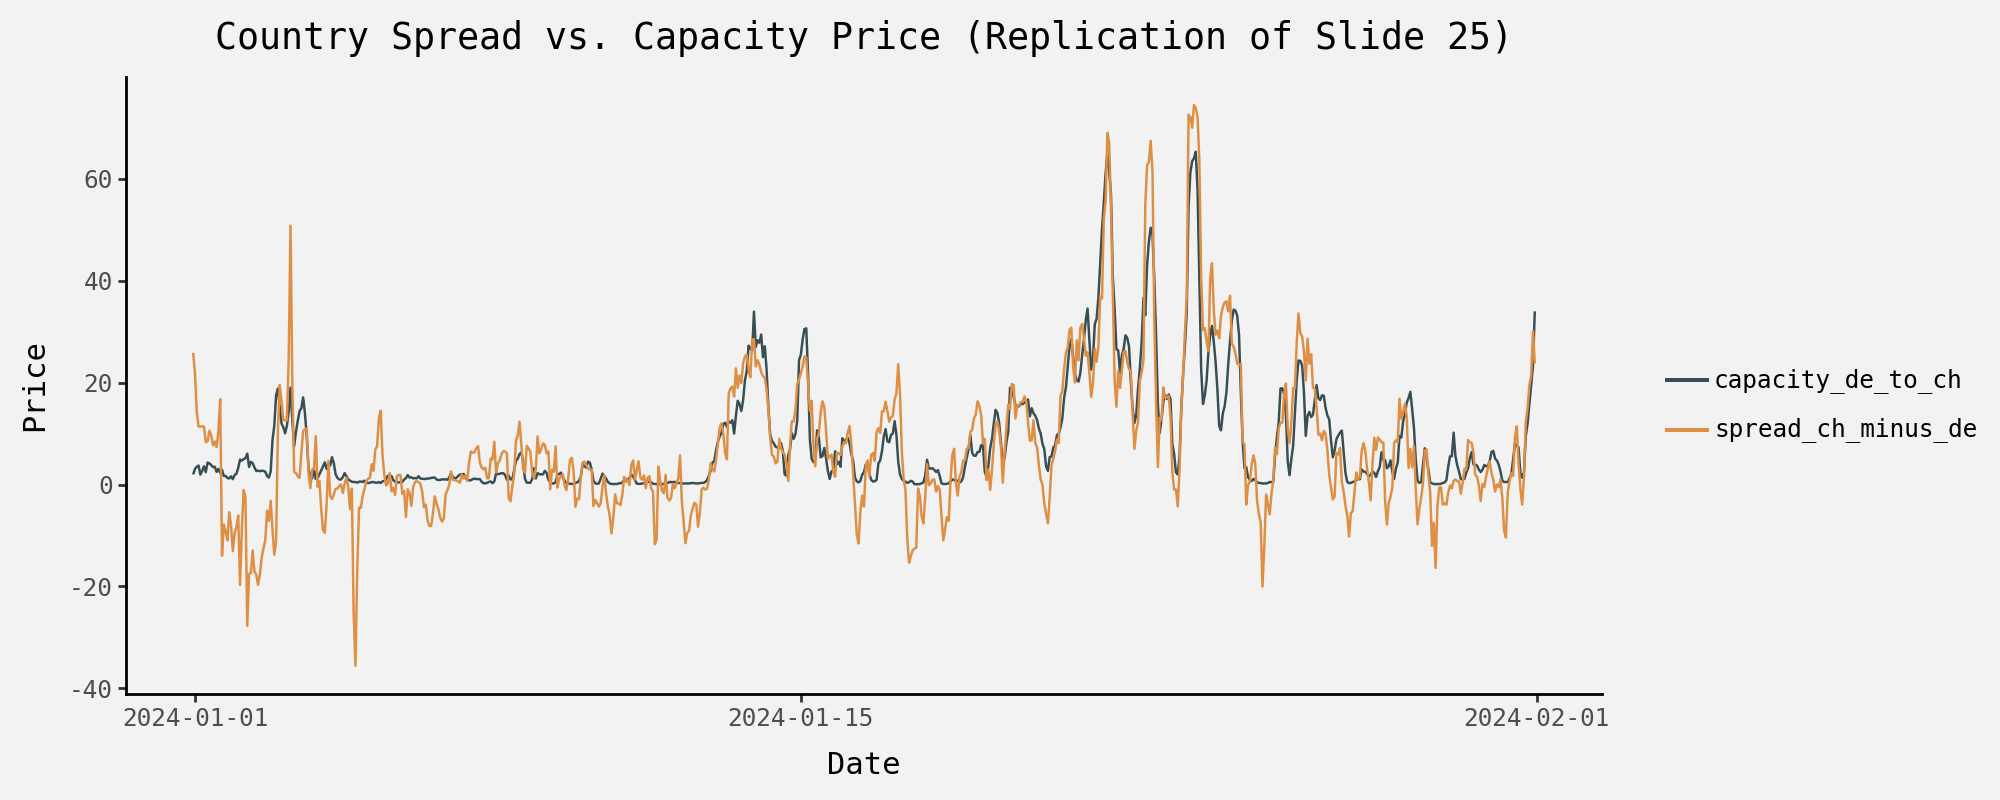

In [62]:
(
    pn.ggplot(
        data=(
            spot_ch.rename(columns={"price": "price_ch"})
            .merge(spot_de.rename(columns={"price": "price_de"}), how="left")
            .assign(spread_ch_minus_de=lambda x: x["price_ch"] - x["price_de"])
            .drop(["price_ch", "price_de"], axis=1)
            .merge(
                capacity_dech.filter(["delivery_begin_time_ch", "price"]).rename(
                    columns={"price": "capacity_de_to_ch"}
                ),
                how="left",
                left_on="date",
                right_on="delivery_begin_time_ch",
            )
            .drop("delivery_begin_time_ch", axis=1)
            .query("date > '2024-01-01'")
            .assign(date=lambda x: pd.to_datetime(x["date"], utc=True))
            .melt("date")
        ),
        mapping=pn.aes(x="date", y="value", colour="variable"),
    )
    + pn.geom_line()
    + pn.labs(title="Country Spread vs. Capacity Price (Replication of Slide 25)", y="Price", x="Date", colour="")
    + pn.scale_colour_manual(values=jama_colour)
    + pn.theme(figure_size=[10, 4])
)

### TBD: Adjusting for DST: Where is the asterisk?

In [84]:
jao_prices.head(3)

,corridor,date,hour,price,allocatedCapacity,ATC,delivery_begin_time_ch
0,CH-DE,01/01/2019,00:00-01:00,0.0,4232,4233,2019-01-01 00:00:00+01:00
1,CH-DE,01/01/2019,01:00-02:00,0.0,4232,4233,2019-01-01 01:00:00+01:00
2,CH-DE,01/01/2019,02:00-03:00,0.0,4232,4233,2019-01-01 02:00:00+01:00


In [82]:
jao_prices.query("'*' in hour")

,corridor,date,hour,price,allocatedCapacity,ATC,delivery_begin_time_ch


In [ ]:
if any(jao_prices.hour.str.contains("*", regex=False)):
    # there is a switch from summer to winter time!
    switchdate = jao_prices.loc[
        jao_prices.hour.str.contains("*", regex=False), "date"
    ].values[0]
    switchindex = jao_prices.loc[
        jao_prices.hour.str.contains("*", regex=False)
    ].index.values[0]
    jao_prices.loc[
        (jao_prices.date == switchdate) & (jao_prices.index >= switchindex),
        "delivery_begin_time_utc",
    ] += timedelta(hours=1)
    print("Adjusted DST Switch on ", switchdate)

jao_prices["delivery_begin_time_utc"] = jao_prices[
    "delivery_begin_time_utc"
].dt.tz_convert("utc")
jao_prices = jao_prices.loc[
    jao_prices.date < import_date.date() + timedelta(days=1)
]  # jao returns next 31 days if possible